## MNIST Classifier

### Frame the problem

4. This particular Problem is unsupervised, and offline.
5. The prompt is to measure performance with accuracy.
7. The minimum accuracy is 97%

### Get the data

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy

from sklearn.datasets import fetch_openml
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"].astype(np.int32)
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [21]:
X_train, X_val, X_test, y_train, y_val, y_test = X[:50000], X[50000:60000], X[60000:], y[:50000], y[50000:60000], y[60000:]

### Explore the data

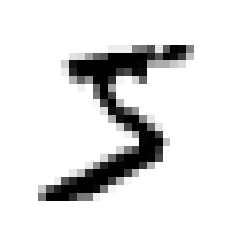

In [5]:
some_digit = X_train[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

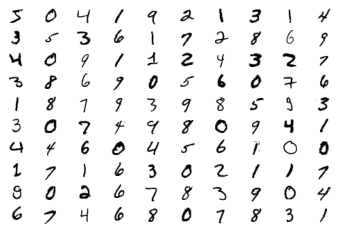

In [6]:
rows, cols = 10, 10
fig, axs = plt.subplots(rows, cols)
for i, digit in enumerate(X_train[:rows*cols]):
    digit_image = digit.reshape(28, 28)
    row = i // rows
    col = i % rows
    axs[row, col].imshow(digit_image, cmap="binary")
    axs[row, col].axis("off")
plt.show() 

In [7]:
y[0]

5

### Clean the data

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Shortlist promising models

In [11]:
def ensemble_all_predictions(clfs, X):
    predictions = np.zeros((len(X), len(clfs)))
    for i, clf in enumerate(clfs):
        predictions[:, i] = clf.predict(X)
    return predictions

def ensemble_predict(clfs, X):
    all_predictions = ensemble_all_predictions(clfs, X)
    return scipy.stats.mode(all_predictions, axis=1).mode.ravel().astype(np.int32)

model SVC(C=50.23310023986688, gamma=0.0005537420375935475) accuracy 0.9744 precision 0.9743721342579607, recall 0.9740990887338482 f1 0.9742070826203986
model ExtraTreesClassifier(n_jobs=-1) accuracy 0.9754 precision 0.9751938185743262, recall 0.975146403535484 f1 0.9751524765608188
model RandomForestClassifier(n_jobs=-1) accuracy 0.9711 precision 0.9709767116589211, recall 0.9708226224965042 f1 0.9708713334600318
model ensemble accuracy 0.9768 precision 0.9766692659919871, recall 0.976552686849358 f1 0.9765950500298664


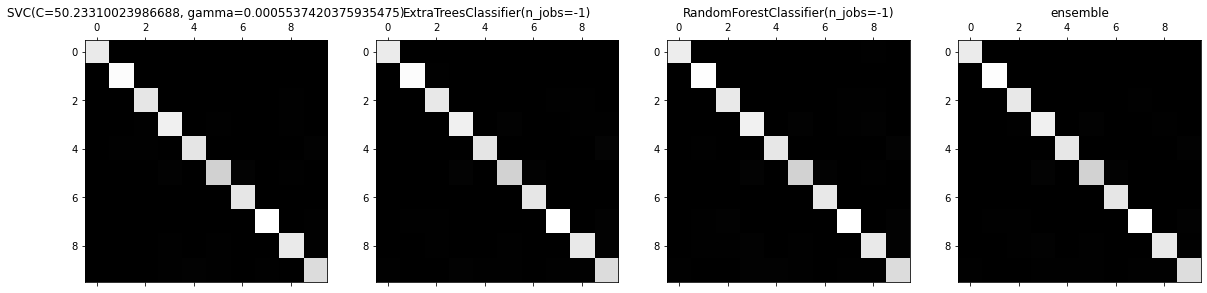

In [10]:
# X_train_scaled = X_train_scaled[:1000]
# y_train = y_train[:1000]

models = [
    # borrowing params from chapter 5 mnist
    SVC(C=50.23310023986688, gamma=0.0005537420375935475), 
    # LinearSVC(),
    # SGDClassifier(n_jobs=-1),
    # LogisticRegression(),
    # SGDClassifier(loss="log", n_jobs=-1),
    ExtraTreesClassifier(n_jobs=-1),
    RandomForestClassifier(n_jobs=-1), 
]

fig, axs = plt.subplots(1, len(models)+1, figsize=(20, 8))
for i, model in enumerate(models):
    model.fit(X_train_scaled, y_train)
    y_val_pred = model.predict(X_val_scaled)
    conf_mx = confusion_matrix(y_val, y_val_pred)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average="macro")
    recall = recall_score(y_val, y_val_pred, average="macro")
    f1 = f1_score(y_val, y_val_pred, average="macro")
    print(f"model {model} accuracy {accuracy} precision {precision}, recall {recall} f1 {f1}")
    axs[i].matshow(conf_mx, cmap=plt.cm.gray)
    axs[i].set_title(str(model))
    
    
y_val_pred = ensemble_predict(models, X_val_scaled)
conf_mx = confusion_matrix(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average="macro")
recall = recall_score(y_val, y_val_pred, average="macro")
f1 = f1_score(y_val, y_val_pred, average="macro")
print(f"model ensemble accuracy {accuracy} precision {precision}, recall {recall} f1 {f1}")
axs[len(models)].matshow(conf_mx, cmap=plt.cm.gray)
axs[len(models)].set_title("ensemble")
plt.show()

In [32]:
Y_val_pred = ensemble_all_predictions(models, X_val_scaled)

param_distribs = [
    {
        'C': scipy.stats.expon(scale=100), 
        'kernel': ['linear'], 
        'class_weight':['balanced', None],
    },
    {
        'C': scipy.stats.expon(scale=100), 
        'gamma': scipy.stats.expon(scale=.1),
        'kernel': ['rbf'], 
        'class_weight':['balanced', None],
    }
]

blender = RandomizedSearchCV(
    SVC(), 
    param_distributions=param_distribs,
    n_iter=1000,
    cv=5,
    scoring="accuracy",
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
blender_search = blender.fit(Y_val_pred, y_val)
print(f"best estimator {blender_search.best_estimator_}\nbest score {blender_search.best_score_}")

blender_search.best_estimator_.fit(Y_val_pred, y_val)
y_val_pred = blender_search.best_estimator_.predict(Y_vals_pred)
accuracy_score(y_val, y_val_pred)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV] END C=159.23005340557225, class_weight=balanced, kernel=linear; total time=  41.9s
[CV] END C=61.47961650819368, class_weight=balanced, kernel=linear; total time=  14.1s
[CV] END C=15.416196746656105, class_weight=balanced, gamma=0.0020799307999138624, kernel=rbf; total time=   1.0s
[CV] END C=128.0129748994866, class_weight=None, gamma=0.0238687625248947, kernel=rbf; total time=   1.2s
[CV] END C=128.0129748994866, class_weight=None, gamma=0.0238687625248947, kernel=rbf; total time=   1.2s
[CV] END C=128.0129748994866, class_weight=None, gamma=0.0238687625248947, kernel=rbf; total time=   1.3s
[CV] END C=485.511460488853, class_weight=balanced, gamma=0.03627537294604771, kernel=rbf; total time=   1.5s
[CV] END C=485.511460488853, class_weight=balanced, gamma=0.03627537294604771, kernel=rbf; total time=   2.0s
[CV] END C=0.709138979446984, class_weight=balanced, gamma=0.034422299255394154, kernel=rbf; total time=   0

0.9831

In [25]:
def stacked_ensemble_predict(clfs, blender, X):
    Y_pred = ensemble_all_predictions(clfs, X)
    y_pred = blender.predict(Y_pred)
    return y_pred

In [27]:
y_test_pred = ensemble_predict(models, X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.9747

In [34]:
y_test_pred = stacked_ensemble_predict(models, blender_search.best_estimator_, X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.9702